# Case: hospital districts


In this tutorial, we will create boundaries of Finnish hospital districts (*sairaanhoitopiiri* in Finnish) by dissolving municipality boundaries into larger entities. Main processing steps include a table join and dissolving the municipality geometries into larger entities.

We will combine information from [municipality polygons](https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html) from Statistics Finland and a [list of health care districts](https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat) by the Finnish Municipality authority Kuntaliitto.

Importing required python packages:

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

## Read in data
- **Municipality polygons** from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html
    - wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs?
    - feature: `tilastointialueet:kunta1000k` (most recent information about municipality polygons)





In [2]:
# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url)

In [3]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2021,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7..."
1,kunta1000k.2,009,2021,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7..."
2,kunta1000k.3,010,2021,Alavus,Alavo,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6..."
3,kunta1000k.4,016,2021,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6..."
4,kunta1000k.5,018,2021,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6..."


In [4]:
# Check length (there are 310 municipalities in Finland in 2020)
len(geodata)

309

In [5]:
#Select and rename columns
geodata.rename(columns={'kunta':'code'}, inplace=True)
geodata = geodata[['code','name', 'geometry']]
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6..."


<AxesSubplot:>

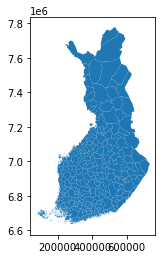

In [6]:
geodata.plot()

In [7]:
geodata.dtypes

code          object
name          object
geometry    geometry
dtype: object

- **Finnish municipalities with hospital district information** as an Excel spreadsheet 
    - Downloaded from: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat in March 2020. 
    - File `Shp_jäsenkunnat_2020.xls`, sheet `kunnat_shp_2020_ aakkosjärj.` This is the original unaltered file.
    - In this file, "shp" stands for "sairaanhoitopiiri" (hospital district in Finnish)
    
*Note: this data set does not include Åland (Ahvenanmaa). Åland municipalities are added in the later step.*
*Note: "hospital districts" is a more proper translation to sairaanhoitopiirit, but in this lesson I use "health care districts" to refer to these entities*

Excel files often come with additional formatting such as metadata on the first lines of the data array. This is why it is a good idea to download the file on your own computer and have a look at the data structure before reading in the file using Python.
It is also often a good idea to save the file as a csv file before reading in the data. However, it is also possible to read in data directly from Excel. For this, you need to have the xlrd module installed:

```
conda install -c conda-forge xlrd
```

Now we are ready to read in the data using pandas.

In the case of this health districts excel the header is located on the 4th row (index 3) of the excel spreadsheet. 

In [8]:
# Read in the excel spreadsheet
data = pd.read_excel(r"data/Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

In [9]:
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
0,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0


In addition, the first row after the header is empty. We can get rid of it using the dropna() -function:

In [10]:
data.dropna(inplace=True)

Check number of rows (16 Åland municipalities are missing)

In [11]:
len(data)

294

The data needs some fixing and cleaning after reading the excel sheet

In [12]:
# Rename columns from Finnish to English 
data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)

# Select only useful columns
data = data[['code','healthCareDistrict']]

In [13]:
data

,code,healthCareDistrict
1,20.0,Pirkanmaa
2,5.0,Etelä-Pohjanmaa
3,9.0,Pohjois-Pohjanmaa
4,10.0,Etelä-Pohjanmaa
5,16.0,Päijät-Häme
...,...,...
290,977.0,Pohjois-Pohjanmaa
291,980.0,Pirkanmaa
292,981.0,Kanta-Häme
293,989.0,Etelä-Pohjanmaa


Looks better! Now we need to prepare the data for table join. We will use the municipality code as the common key.

In [14]:
data.dtypes

code                  float64
healthCareDistrict     object
dtype: object

The code column is currently a floating point number. We need to modify these codes so that they match the ones in the spatial data:

In [15]:
# Example using one code
number = data.at[1, "code"]
number

20.0

In [16]:
# Conver this number to character string 020
print("20".zfill(3))

020


Let's apply this process on all rows at once, and take into account different number of digits:

In [17]:
# Convert to character string
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
data["code"] = data["code"].str.zfill(3)

In [18]:
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


## Join Health district info to the municipality polygons

In [19]:
# Merge health district info to geodata using "code" as the common key
geodata = geodata.merge(data, on="code", how="left")

In [20]:
geodata

,code,name,geometry,healthCareDistrict
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7...",Etelä-Pohjanmaa
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7...",Pohjois-Pohjanmaa
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6...",Etelä-Pohjanmaa
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6...",Päijät-Häme
4,018,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6...",HUS
...,...,...,...,...
304,977,Ylivieska,"POLYGON ((398010.991 7110887.267, 392464.690 7...",Pohjois-Pohjanmaa
305,980,Ylöjärvi,"POLYGON ((313738.511 6896936.100, 311165.511 6...",Pirkanmaa
306,981,Ypäjä,"POLYGON ((297451.456 6756204.328, 291432.640 6...",Kanta-Häme
307,989,Ähtäri,"POLYGON ((348733.187 6959704.551, 347302.684 6...",Etelä-Pohjanmaa


Looks good! However, Municipalities in the Åland island did not have a matching health care district in the data. Let's have a closer look: 

In [21]:
# List all municipalities that lack health district info:
geodata[geodata["healthCareDistrict"].isnull()].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
57         Jomala
111      Kumlinge
121         Kökar
134       Lemland
147    Lumparland
153     Mariehamn
236       Saltvik
254      Sottunga
256          Sund
301         Vårdö
Name: name, dtype: object

In [22]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"

Check the count of municipalities per health care disctrict

In [23]:
geodata["healthCareDistrict"].value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Pohjois-Savo         18
Etelä-Pohjanmaa      18
Ahvenanmaa           16
Satakunta            16
Lappi                15
Vaasa                13
Pohjois-Karjala      13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Karjala         9
Etelä-Savo            9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

## Create polygons for health care districts 

In [24]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict')

In [25]:
districts.reset_index(inplace=True)

In [26]:
# Select useful columns
districts = districts[["healthCareDistrict", "geometry"]]

In [27]:
districts

,healthCareDistrict,geometry
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136..."
1,Etelä-Karjala,"POLYGON ((538858.650 6740202.117, 536909.932 6..."
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6..."
3,Etelä-Savo,"POLYGON ((520334.347 6786709.482, 520632.817 6..."
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418..."
5,Itä-Savo,"POLYGON ((603980.674 6824572.057, 600339.558 6..."
6,Kainuu,"POLYGON ((643098.600 7165870.100, 643537.000 7..."
7,Kanta-Häme,"POLYGON ((369728.766 6728123.905, 366878.133 6..."
8,Keski-Pohjanmaa,"MULTIPOLYGON (((302835.219 7083897.220, 302801..."
9,Keski-Suomi,"POLYGON ((439110.805 6852598.036, 439300.113 6..."


(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

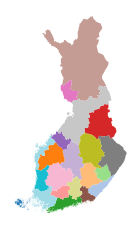

In [28]:
districts.plot(column='healthCareDistrict', cmap='tab20', k=20)
plt.axis('off')

In [29]:
# Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')

In [30]:
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')

That's it! You can elaborate this workflow by joining additional data. For example, if you join population info per municipality you can sum it up for each health care district using the `aggfunc=sum` argument to get population count per health care district.